### Instructor Demo: Financial Forecasting Part III

This program executes `1000` simulations of stock price trajectory for `TSLA` and `SPHD` over the next `252 * 3` trading days (or 3 years of trading), based on a normal probability distribution of potential daily returns derived from the corresponding sample means and standard deviations. Daily and cumulative portfolio returns are then calculated, using `75%` of capital allocated to `TSLA` and `25%` of capital allocated to `SPHD`, to analyze the probability distribution and confidence interval of potential ending cumulative portfolio returns.

In [1]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline

In [2]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

### Check Available Tickers from Alpaca Markets API

In [3]:
# Get all Asstes
assets = api.list_assets()

# Keep only tradeable assets
tradeable = [asset for asset in assets if asset.tradable ]
tradeable

[Asset({   'class': 'us_equity',
     'easy_to_borrow': False,
     'exchange': 'ARCA',
     'id': '02b6820c-e5d5-462f-b3d0-d600919dffd7',
     'marginable': True,
     'name': 'Direxion Daily Gold Miners Bull 3X Shares of Direxion Shares ETF '
             'Trust',
     'shortable': False,
     'status': 'active',
     'symbol': 'NUGT',
     'tradable': True}),
 Asset({   'class': 'us_equity',
     'easy_to_borrow': False,
     'exchange': 'NASDAQ',
     'id': 'd174dc71-0a75-47a7-a43c-5cf9360111bf',
     'marginable': True,
     'name': 'ETF Series Solutions Trust Loncar Cancer Immunotherapy ETF',
     'shortable': False,
     'status': 'active',
     'symbol': 'CNCR',
     'tradable': True}),
 Asset({   'class': 'us_equity',
     'easy_to_borrow': False,
     'exchange': 'NASDAQ',
     'id': '07844fc5-d49c-41dd-a543-dccaf6aec65c',
     'marginable': True,
     'name': 'Co-Diagnostics, Inc. Common Stock',
     'shortable': False,
     'status': 'active',
     'symbol': 'CODX',
     't

### Get 1 Year's Worth of Data via API Call and Read in as DataFrame 

In [4]:
# Set the list of tickers
tickers = ["TSLA", "SPHD"]

# Set timeframe to '1D'
timeframe = '1D'

# Set start and end datetimes of 1 year, between now and 365 days ago.
end_date = datetime.now()
start_date = end_date + timedelta(-365)

# Get 1 year's worth of historical data for AAPL
df = api.get_barset(
    tickers,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

df.head()

SPHD                                     TSLA  \
                            open     high      low  close  volume    open   
2019-11-04 00:00:00-05:00  43.15  43.5194  43.1100  43.49  468854  314.80   
2019-11-05 00:00:00-05:00  43.41  43.5550  43.2400  43.35  428631  319.62   
2019-11-06 00:00:00-05:00  43.39  43.4960  43.1602  43.25  434993  318.00   
2019-11-07 00:00:00-05:00  43.44  43.4900  43.1800  43.25  575911  329.14   
2019-11-08 00:00:00-05:00  43.15  43.2600  42.9800  43.26  445627  334.50   

                                                               
                             high      low    close    volume  
2019-11-04 00:00:00-05:00  321.94  309.260  317.425   8579754  
2019-11-05 00:00:00-05:00  323.51  316.118  317.160   6308975  
2019-11-06 00:00:00-05:00  326.72  314.500  326.700   7748529  
2019-11-07 00:00:00-05:00  341.50  328.020  335.390  14148570  
2019-11-08 00:00:00-05:00  337.46  332.500  337.120   5966814

### Drop Extraneous Columns

In [5]:
# Use the `drop` function with the `level` parameter to drop extra columns in the multi-index DataFrame
df.drop(columns=['open', 'high', 'low', 'volume'], level=1, inplace=True)
df.head()

,SPHD,TSLA
,close,close
2019-11-04 00:00:00-05:00,43.49,317.425
2019-11-05 00:00:00-05:00,43.35,317.160
2019-11-06 00:00:00-05:00,43.25,326.700
2019-11-07 00:00:00-05:00,43.25,335.390
2019-11-08 00:00:00-05:00,43.26,337.120


### Calculate Daily Returns

In [6]:
# Use the `pct_change` function to calculate daily returns of `TSLA` and `SPHD`.
daily_returns = df.pct_change()
daily_returns.head()

,SPHD,TSLA
,close,close
2019-11-04 00:00:00-05:00,NaN,NaN
2019-11-05 00:00:00-05:00,-0.003219,-0.000835
2019-11-06 00:00:00-05:00,-0.002307,0.030079
2019-11-07 00:00:00-05:00,0.000000,0.026599
2019-11-08 00:00:00-05:00,0.000231,0.005158


### Calculate Value of Average Daily Returns

In [7]:
# Use the `mean` function to calculate the mean of daily returns for `TLSA` and `SPHD`, respectively
avg_daily_return_tsla = daily_returns.mean()['TSLA']['close']
avg_daily_return_sphd = daily_returns.mean()['SPHD']['close']
avg_daily_return_sphd

-0.003265788769029799

### Calculate Value of Standard Deviation of Daily Returns

In [8]:
# Use the `std` function to calculate the standard deviation of daily returns for `TSLA` and `SPHD`, respectively
std_dev_daily_return_tsla = daily_returns.std()['TSLA']['close']
std_dev_daily_return_sphd = daily_returns.std()['SPHD']['close']
std_dev_daily_return_sphd

0.029898069692506447

### Run the Monte Carlo Simulation and Save Results to DataFrame

In [9]:
# Set number of simulations and trading days
num_simulations = 1000
num_trading_days = 252 * 3

# Set last closing prices of `TSLA` and `SPHD`
tsla_last_price = df['TSLA']['close'][-1]
sphd_last_price = df['SPHD']['close'][-1]

# Initialize empty DataFrame to hold simulated prices for each simulation
simulated_price_df = pd.DataFrame()
portfolio_cumulative_returns = pd.DataFrame()

# Run the simulation of projecting stock prices for the next trading year, `1000` times
for n in range(num_simulations):

    # Initialize the simulated prices list with the last closing price of `TSLA` and `SPHD`
    simulated_tsla_prices = [tsla_last_price]
    simulated_sphd_prices = [sphd_last_price]
    
    # Simulate the returns for 252 * 3 days
    for i in range(num_trading_days):
        
        # Calculate the simulated price using the last price within the list
        simulated_tsla_price = simulated_tsla_prices[-1] * (1 + np.random.normal(avg_daily_return_tsla, std_dev_daily_return_tsla))
        simulated_sphd_price = simulated_sphd_prices[-1] * (1 + np.random.normal(avg_daily_return_sphd, std_dev_daily_return_sphd))
        
        # Append the simulated price to the list
        simulated_tsla_prices.append(simulated_tsla_price)
        simulated_sphd_prices.append(simulated_sphd_price)
    
    # Append a simulated prices of each simulation to DataFrame
    simulated_price_df["TSLA prices"] = pd.Series(simulated_tsla_prices)
    simulated_price_df["SPHD prices"] = pd.Series(simulated_sphd_prices)
    
    # Calculate the daily returns of simulated prices
    simulated_daily_returns = simulated_price_df.pct_change()
    
    # Set the portfolio weights (75% TSLA; 25% SPHD)
    weights = [0.25, 0.75]

    # Use the `dot` function with the weights to multiply weights with each column's simulated daily returns
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    
    # Calculate the normalized, cumulative return series
    portfolio_cumulative_returns[n] = (1 + portfolio_daily_returns.fillna(0)).cumprod()

# Print records from the DataFrame
portfolio_cumulative_returns.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.008625,1.020770,1.018185,0.954032,1.045478,1.027723,0.938168,0.993210,0.989629,0.996348,...,1.010596,0.980599,1.047465,1.018549,0.987406,1.045653,1.001087,0.978419,0.977755,1.052945
2,1.001087,1.013937,1.053252,0.935946,1.078160,1.045402,0.927857,0.972032,1.013676,0.990669,...,1.015926,1.033352,1.047943,1.014139,0.923374,1.066792,0.945305,0.956695,0.967139,1.060854
3,0.938488,1.003048,1.056586,0.925854,0.996553,1.040917,0.910244,0.960723,0.987195,0.995343,...,0.977941,1.036537,1.081162,1.038384,0.877371,1.052744,0.924381,0.989130,0.965931,1.058768
4,0.938807,1.023696,1.004186,0.949178,0.993921,1.078758,0.922861,0.969859,0.999141,0.985066,...,1.013683,1.076739,1.070021,0.979719,0.870064,1.054891,0.914834,0.957639,0.972231,1.097170


### Plot the Multiple Simulations of Potential Cumulative Portfolio Returns over the Next 3 Years (252 * 3 Trading Days)

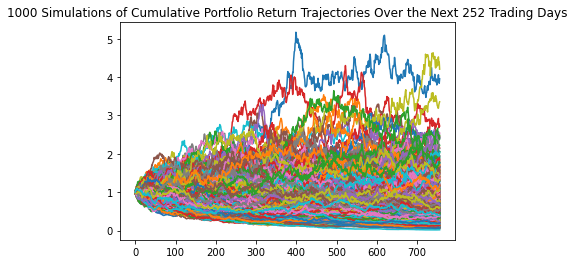

In [10]:
# Use the `plot` function to plot `1000` simulations of the potential trajectories of the portfolio based on 252 trading days
plot_title = f"{n+1} Simulations of Cumulative Portfolio Return Trajectories Over the Next 252 Trading Days"
portfolio_cumulative_returns.plot(legend=None, title=plot_title)

In [11]:
# Select the last row for project stock prices (prices of each simulation on the last trading day)
ending_cumulative_returns = portfolio_cumulative_returns.iloc[-1, :]
ending_cumulative_returns.head()

0    3.955462
1    0.203802
2    0.470042
3    2.156109
4    0.527991
Name: 756, dtype: float64

### Plot the Frequency Distribution of Simulated Ending Portfolio Cumulative Returns on the Last Trading Day

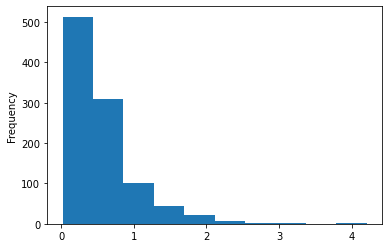

In [12]:
# Use the `plot` function to plot a frequency distribution of simulated ending prices
ending_cumulative_returns.plot(kind='hist', bins=10)

### Calculate the Probability Distribution of Ending Cumulative Return Ranges

In [13]:
# Use the `value_counts` function and the `len` function to calculate the probabilities of cumulative return ranges
ending_cumulative_returns.value_counts(bins=10) / len(ending_cumulative_returns)

(0.014499999999999999, 0.438]    0.513
(0.438, 0.857]                   0.308
(0.857, 1.276]                   0.101
(1.276, 1.695]                   0.044
(1.695, 2.114]                   0.021
(2.114, 2.532]                   0.008
(3.789, 4.208]                   0.002
(2.532, 2.951]                   0.002
(2.951, 3.37]                    0.001
(3.37, 3.789]                    0.000
Name: 756, dtype: float64

### Calculate Lower and Upper Bounds of 95% Confidence Interval for Simulated Ending Cumulative Portfolio Returns

In [14]:
# Use the `quantile` function to calculate the 95% confidence interval for simulated ending prices
confidence_interval = ending_cumulative_returns.quantile(q=[0.025, 0.975])
confidence_interval

0.025    0.098747
0.975    1.778882
Name: 756, dtype: float64

### Plot the Probability Distribution and 95% Confidence Interval of Simulated Ending Cumulative Portfolio Returns 

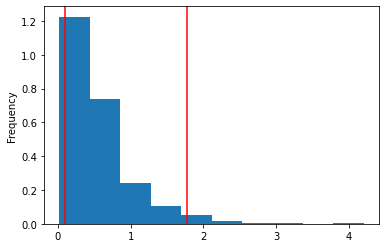

In [15]:
# Use the `plot` function to create a probability distribution histogram of simulated ending prices
# with markings for a 95% confidence interval
plt.figure();
ending_cumulative_returns.plot(kind='hist', density=True, bins=10)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

### Calculate 95% Confidence Interval of An Initial Investment of 10,000 in the Portfolio over the Next 3 Trading Years

In [16]:
# Set initial investment
initial_investment = 10000

# Calculate investment profit/loss of lower and upper bound cumulative portfolio returns
investment_pnl_lower_bound = initial_investment * confidence_interval.iloc[0]
investment_pnl_upper_bound = initial_investment * confidence_interval.iloc[1]
                                                    
# Print the results
print(f"There is a 95% chance that an initial investment of $10,000 in the portfolio"
      f" over the next 252 * 3 trading days will end within in the range of"
      f" ${investment_pnl_lower_bound} and ${investment_pnl_upper_bound}")

There is a 95% chance that an initial investment of $10,000 in the portfolio over the next 252 * 3 trading days will end within in the range of $987.4729035529564 and $17788.819054867756


### Answer the Following Questions

* What is the expected range of projected cumulative returns of the given portfolio?
* What is the `95%` confidence interval of projected cumulative returns of the given portfolio?
* What is the `95%` confidence interval of projected cumulative investment for the given portfolio?

* The expected range of projected cumulative returns for the portfolio is between 0.671 and 0.833 with a 24.2% chance of occurring.
* The `95` confidence interval of projected cumulative returns is between 0.514393 and 1.570911.
* The `95` confidencc interval of projected cumulative investment is between 5143.93 and 15709.11.